In [19]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.inspection import (partial_dependence, PartialDependenceDisplay, permutation_importance)

# Criação de dataset unificado

In [4]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [5]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [6]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [7]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [16]:
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
all_data.append(numpy_data)
combined_data = np.concatenate(all_data, axis=0)
column_names = ["bvp", "hr", "eda", "temp", "label"]
df = pd.DataFrame(data=combined_data, columns=column_names)

# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df = df.drop_duplicates()

In [17]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
6,-0.38,101.00,2.015176,33.39,0.0
17,-0.36,101.00,2.015176,33.39,0.0
20,-0.36,106.50,2.015176,33.39,0.0
28,-0.75,106.50,2.015176,33.39,0.0
...,...,...,...,...,...
4143942,-2.09,73.65,0.783331,31.81,0.0
4143951,-3.28,73.65,0.783331,31.81,0.0
4143962,-4.43,73.65,0.783331,31.81,0.0
4143973,-5.44,73.65,0.783331,31.81,0.0


In [18]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### NORMALIZAR E CRIAR MIN, MEAN, MAX

In [15]:
def calculate_and_normalize_stats(df, column_name):
    min_values = []
    max_values = []
    mean_values = []

    for i in range(0, len(df), 3):
        values = df[column_name].iloc[i:i+3]
        min_values.append(values.min())
        max_values.append(values.max())
        mean_values.append(values.mean())
    
    stats = pd.DataFrame({
        f'{column_name}_min': min_values,
        f'{column_name}_max': max_values,
        f'{column_name}_mean': mean_values
    })
    
    min_array = np.array(stats[f'{column_name}_min'])
    max_array = np.array(stats[f'{column_name}_max'])
    mean_array = np.array(stats[f'{column_name}_mean'])

    normalized_min = preprocessing.normalize([min_array]).flatten()
    normalized_max = preprocessing.normalize([max_array]).flatten()
    normalized_mean = preprocessing.normalize([mean_array]).flatten()

    data_normalized = {
        f'normalized_{column_name}_mean': normalized_mean,
        f'normalized_{column_name}_max': normalized_max,
        f'normalized_{column_name}_min': normalized_min,
    }
    
    return pd.DataFrame(data_normalized)

df_temp = calculate_and_normalize_stats(df, 'temp')
df_eda = calculate_and_normalize_stats(df, 'eda')
df_hr = calculate_and_normalize_stats(df, 'hr')

df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
158904,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002401,0.002400,0.002402
158905,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002394,0.002400,0.002391
158906,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002390,0.002389,0.002391
158907,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379
158908,0.00244,0.00244,0.00244,0.001766,0.001765,0.001766,0.002378,0.002376,0.002379


In [21]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})

# Aplicando algoritmos de classificação

In [22]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

### knn

In [24]:
k_nearest_neighbors = KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform")
k_nearest_neighbors.fit(X_train, y_train.ravel())
y_pred_knn = k_nearest_neighbors.predict(X_test)
f1score   = f1_score        (y_test, y_pred_knn, average = 'macro')
recall    = recall_score    (y_test, y_pred_knn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_knn)
AUC       = roc_auc_score   (y_test.ravel(), k_nearest_neighbors.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.991591047189687
acc = 0.9490067753235584
f1 = 0.9442958738494482
recall = 0.9461815087771754


### Logistic Regression

In [26]:
logistic_regression = LogisticRegression(penalty="l2", C=1.0, max_iter=999)
logistic_regression.fit(X_train, y_train.ravel())

y_pred_lr = logistic_regression.predict(X_test)
f1score   = f1_score        (y_test, y_pred_lr, average = 'macro')
recall    = recall_score    (y_test, y_pred_lr, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_lr)
AUC       = roc_auc_score   (y_test.ravel(), logistic_regression.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.7752635523657919
acc = 0.47582489039917775
f1 = 0.12896513495458875
recall = 0.2


### RF

In [27]:
clf = RandomForestClassifier(n_estimators=100,max_depth=15)
clf.fit(X_train, y_train.ravel())
y_pred_rf = clf.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clf.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9995730036778706
acc = 0.9830302267530887
f1 = 0.9818329421849252
recall = 0.9832766565076068


### neural network

In [27]:
neural_network = MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999)

neural_network.fit(X_train, y_train.ravel())

y_pred_nn = neural_network.predict(X_test)
f1score   = f1_score        (y_test, y_pred_nn, average = 'macro')
recall    = recall_score    (y_test, y_pred_nn, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_nn)
AUC       = roc_auc_score   (y_test.ravel(), neural_network.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

auc = 0.9151336182842549
acc = 0.6323705241960859
f1 = 0.3520636142080964
recall = 0.37913631801433884


c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (999) reached and the optimization hasn't converged yet.
  warnings.warn(


### SVM

In [28]:
support_vector_machine = SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
support_vector_machine.fit(X_train, y_train.ravel())
y_pred_svm = support_vector_machine.predict(X_test)

f1score   = f1_score        (y_test, y_pred_svm, average = 'macro')
recall    = recall_score    (y_test, y_pred_svm, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_svm)
AUC       = roc_auc_score   (y_test.ravel(), support_vector_machine.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall) 

KeyboardInterrupt: 

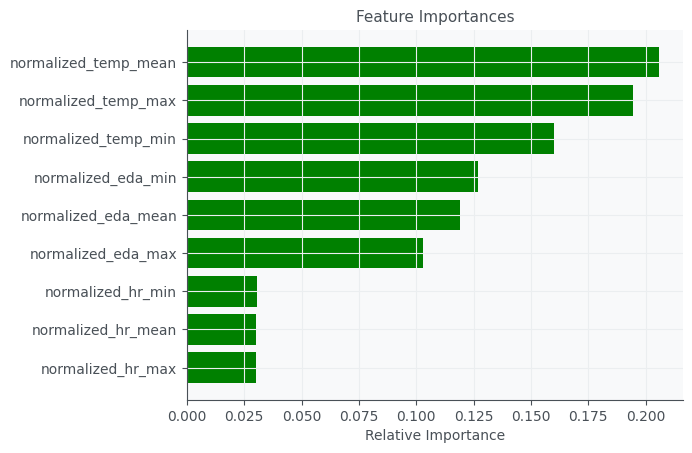

In [ ]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

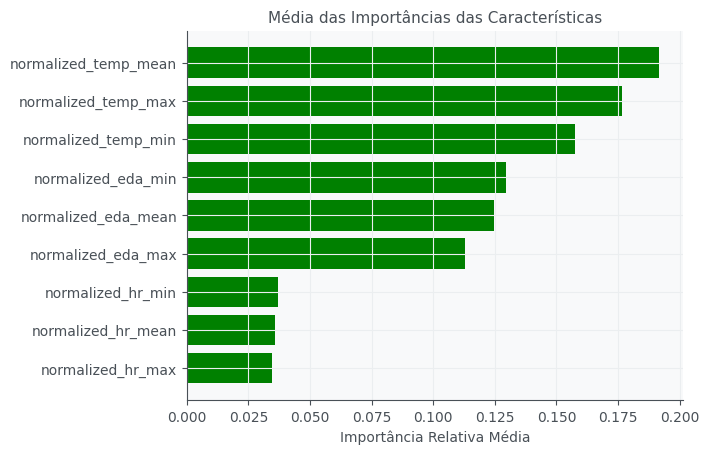

In [ ]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()

# Criação de datasets individuais

In [28]:
dfs = {}
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)
    
    user_data = []

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    eda = obj['signal']['wrist']['EDA'][:, 0]
                    temp = obj['signal']['wrist']['TEMP'][:, 0]
                    label = obj['label']

                    len_label = len(label)
                    len_temp_eda = len(temp)

                    total_time = len_label / fs_label

                    time_label = np.linspace(0, total_time, len_label, endpoint=False)
                    time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)

                    interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
                    interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')

                    aligned_temp = interp_temp(time_label)
                    aligned_eda = interp_eda(time_label)

                    user_data.append((aligned_eda, aligned_temp, label))

    # Processar os dados de frequência cardíaca (HR)
    hr_data = []
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

    if hr_data:
        combined_hr_df = pd.concat(hr_data, ignore_index=True)
        hr = combined_hr_df.iloc[:, 0].to_numpy()

        len_hr = len(hr)
        time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
        interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
        aligned_hr = interp_hr(time_label)

        for eda, temp, label in user_data:
            numpy_data = np.column_stack((aligned_hr, eda, temp, label))
            # Adicionar os dados ao dataframe específico do usuário
            if folder_name not in dfs:
                dfs[folder_name] = []
            dfs[folder_name].append(numpy_data)

# Processar cada dataframe de usuário para calcular e normalizar as estatísticas
for key in dfs:
    combined_data = np.concatenate(dfs[key], axis=0)
    column_names = ["hr", "eda", "temp", "label"]
    df = pd.DataFrame(data=combined_data, columns=column_names)
    
    # Filtrar os dados com base nos rótulos desejados
    df = df[df['label'] != 7.0]
    df = df[df['label'] != 6.0]
    df = df[df['label'] != 5.0]
    df = df.drop_duplicates()
    
    # Função para calcular estatísticas e normalizar
    def calculate_and_normalize_stats(df, column):
        min_vals, max_vals, mean_vals = [], [], []
        for i in range(0, len(df), 3):
            vals = df[column].iloc[i:i+3]
            min_vals.append(vals.min())
            max_vals.append(vals.max())
            mean_vals.append(vals.mean())
        stats_df = pd.DataFrame({f'{column}_min': min_vals, f'{column}_max': max_vals, f'{column}_mean': mean_vals})
        normalized_mean = preprocessing.normalize([stats_df[f'{column}_mean'].to_numpy()]).flatten()
        normalized_max = preprocessing.normalize([stats_df[f'{column}_max'].to_numpy()]).flatten()
        normalized_min = preprocessing.normalize([stats_df[f'{column}_min'].to_numpy()]).flatten()
        return pd.DataFrame({f'normalized_{column}_mean': normalized_mean,
                            f'normalized_{column}_max': normalized_max,
                            f'normalized_{column}_min': normalized_min})

    # Calcular e normalizar estatísticas para temperatura, EDA e HR
    df_temp = calculate_and_normalize_stats(df, 'temp')
    df_eda = calculate_and_normalize_stats(df, 'eda')
    df_hr = calculate_and_normalize_stats(df, 'hr')

    # Combinar os dataframes normalizados
    df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
    
    # Calcular a média dos labels para cada janela de 3 amostras
    label_mean = []
    for i in range(0, len(df), 3):
        label = df['label'].iloc[i:i+3] 
        label_mean.append(label.mean())
    label_stats = pd.DataFrame({'label_mean': label_mean})
    
    # Armazenar o dataframe normalizado no dicionário
    dfs[key] = pd.concat([df_normalizado, label_stats], axis=1)
    dfs[key] = dfs[key].drop_duplicates()

# Criar variáveis individuais dfs2 a dfs17
for i in list(range(2, 12)) + list(range(13, 18)):
    globals()[f'dfs{i}'] = dfs[f'S{i}']

### aplicando series temporais

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn import metrics

In [ ]:
X = dfs2.drop(columns=["label_mean"]) 
y = dfs2["label_mean"].astype(int)
X_train_skt, X_test_skt, y_train_skt, y_test_skt = temporal_train_test_split(X, y, test_size=0.3)
X_train_array = X_train_skt.values
X_test_array = X_test_skt.values
print("X_train_array shape:", X_train_array.shape)
print("X_test_array shape:", X_test_array.shape)

X_train_array shape: (5559, 9)
X_test_array shape: (2383, 9)


In [ ]:

tsf = TimeSeriesForestClassifier(n_estimators=50, random_state=47)
tsf.fit(X_train_array, y_train_skt)

tsf_preds = tsf.predict(X_test_array)
print("TSF Accuracy: " + str(metrics.accuracy_score(y_test_skt, tsf_preds)))

TSF Accuracy: 0.44020142677297525


### criando a coluna de timestamps

In [ ]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2000)
rocket.fit(X_train_array, y_train_skt)
y_pred = rocket.predict(X_test_array)



In [ ]:
acc = accuracy_score(y_test_skt, y_pred)
acc

0.2710868652958456

## Usar algoritmo treinado em datasets individuais

### random forest

In [30]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_rf = clf.predict(X)
    f1score = f1_score(y, y_pred_rf, average='macro')
    recall = recall_score(y, y_pred_rf, average='macro')
    accuracy = accuracy_score(y, y_pred_rf)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)
    


 Dataset: dfs2
auc = 0.5165368538863706
acc = 0.19894233190632082
f1 = 0.07616944270333034
recall = 0.2045337849428853

 Dataset: dfs3
auc = 0.446070956778469
acc = 0.18846153846153846
f1 = 0.06565722167395562
recall = 0.19460655786312442

 Dataset: dfs4
auc = 0.485962070639565
acc = 0.16795765556416214
f1 = 0.062226629713443546
recall = 0.2036346245815399

 Dataset: dfs5
auc = 0.5853386797553342
acc = 0.1868950940037824
f1 = 0.07065066612048822
recall = 0.19483637975050372

 Dataset: dfs6
auc = 0.5597736637280158
acc = 0.1587572226958416
f1 = 0.06246547724170368
recall = 0.20345456880613377

 Dataset: dfs7
auc = 0.5
acc = 0.22881146528292562
f1 = 0.07448220390106576
recall = 0.2

 Dataset: dfs8
auc = 0.5
acc = 0.20211515863689777
f1 = 0.06725317693059628
recall = 0.2

 Dataset: dfs9
auc = 0.5674306003637204
acc = 0.20106445890005914
f1 = 0.06755867442580729
recall = 0.18820414612367392

 Dataset: dfs10
auc = 0.5935140057956612
acc = 0.21219578889800383
f1 = 0.0721315102164484
recall 

### knn

In [31]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_knn = k_nearest_neighbors.predict(X)
    f1score = f1_score(y, y_pred_knn, average='macro')
    recall = recall_score(y, y_pred_knn, average='macro')
    accuracy = accuracy_score(y, y_pred_knn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.5165368538863706
acc = 0.2280282044824981
f1 = 0.1449718932271763
recall = 0.2070540163914119

 Dataset: dfs3
auc = 0.446070956778469
acc = 0.2294044665012407
f1 = 0.16367826874512809
recall = 0.29219239480545883

 Dataset: dfs4
auc = 0.485962070639565
acc = 0.14304156984249936
f1 = 0.07143776494404405
recall = 0.21166905786704926

 Dataset: dfs5
auc = 0.5853386797553342
acc = 0.3143842474135054
f1 = 0.1529238440169418
recall = 0.2290396817197426

 Dataset: dfs6
auc = 0.5597736637280158
acc = 0.18044899119067917
f1 = 0.10468375280747391
recall = 0.13200486606997303

 Dataset: dfs7
auc = 0.5
acc = 0.41018038052878675
f1 = 0.20274804493900406
recall = 0.28607564020281717

 Dataset: dfs8
auc = 0.5
acc = 0.27893654524089306
f1 = 0.12926545120835703
recall = 0.23048861308591398

 Dataset: dfs9
auc = 0.5674306003637204
acc = 0.2440863394441159
f1 = 0.12930855789883142
recall = 0.15859781918948576

 Dataset: dfs10
auc = 0.5935140057956612
acc = 0.09133169264424391
f1 =

### logistic regression

In [32]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_lr = logistic_regression.predict(X)
    f1score = f1_score(y, y_pred_lr, average='macro')
    recall = recall_score(y, y_pred_lr, average='macro')
    accuracy = accuracy_score(y, y_pred_lr)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.5165368538863706
acc = 0.4687736086628053
f1 = 0.1508265685905968
recall = 0.1880990887055271

 Dataset: dfs3
auc = 0.446070956778469
acc = 0.5112903225806451
f1 = 0.17745023770382548
recall = 0.2138091264512904

 Dataset: dfs4
auc = 0.485962070639565
acc = 0.5213013168086754
f1 = 0.150615441999254
recall = 0.19311334289813487

 Dataset: dfs5
auc = 0.5853386797553342
acc = 0.48748470352653245
f1 = 0.1391331957453564
recall = 0.18666666666666668

 Dataset: dfs6
auc = 0.5597736637280158
acc = 0.5849199583214928
f1 = 0.1570847112693971
recall = 0.19734739533397253

 Dataset: dfs7
auc = 0.5
acc = 0.42117617988633554
f1 = 0.1185429887855342
recall = 0.2

 Dataset: dfs8
auc = 0.5
acc = 0.4049647473560517
f1 = 0.1263482048971008
recall = 0.17864275816363415

 Dataset: dfs9
auc = 0.5674306003637204
acc = 0.3710821998817268
f1 = 0.11853600944510034
recall = 0.17127260320709656

 Dataset: dfs10
auc = 0.5935140057956612
acc = 0.3921246923707957
f1 = 0.12364733778831645
rec

### neural network

In [ ]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_nn = neural_network.predict(X)
    f1score = f1_score(y, y_pred_nn, average='macro')
    recall = recall_score(y, y_pred_nn, average='macro')
    accuracy = accuracy_score(y, y_pred_nn)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.5195385403372607
acc = 0.2428859229413246
f1 = 0.10933774519017159
recall = 0.21146199316692832

 Dataset: dfs3
auc = 0.4469691427889039
acc = 0.2161290322580645
f1 = 0.09397633456027617
recall = 0.1892008924222171

 Dataset: dfs4
auc = 0.4874160237291387
acc = 0.17699457784663053
f1 = 0.07386331633049688
recall = 0.2069823051171688

 Dataset: dfs5
auc = 0.588977947355439
acc = 0.2183780175770386
f1 = 0.0912430701536217
recall = 0.21380191693290734

 Dataset: dfs6
auc = 0.5571056705645653
acc = 0.16122004357298475
f1 = 0.06648015737014164
recall = 0.2065196548418025

 Dataset: dfs7
auc = 0.5
acc = 0.22881146528292562
f1 = 0.07448220390106576
recall = 0.2

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.2460340775558167
f1 = 0.10563837751000701
recall = 0.2192847029762622

 Dataset: dfs9
auc = 0.5491371925339716
acc = 0.2486694263749261
f1 = 0.10359514765773384
recall = 0.21637666325486182

 Dataset: dfs10
auc = 0.5933788533261224
acc = 0.23243095433415367
f1 = 

### SVM

In [ ]:
for i in list(range(2, 12)) + list(range(13, 18)):
    dataset_name = f'dfs{i}'
    dataset = globals().get(dataset_name)
    
    X = dataset.drop(columns=["label_mean"])
    y = dataset["label_mean"].astype(int)
    
    y_pred_svm = support_vector_machine.predict(X)
    f1score = f1_score(y, y_pred_svm, average='macro')
    recall = recall_score(y, y_pred_svm, average='macro')
    accuracy = accuracy_score(y, y_pred_svm)
    AUC = roc_auc_score(y.ravel(), clf.predict_proba(X), multi_class='ovr')

    # Imprimir as métricas
    print(f"\n Dataset: {dataset_name}")
    print('auc =', AUC)
    print('acc =', accuracy)
    print('f1 =', f1score)
    print('recall =', recall)


 Dataset: dfs2
auc = 0.5195385403372607
acc = 0.35696298161672124
f1 = 0.14501984883914293
recall = 0.17430749346222496

 Dataset: dfs3
auc = 0.4469691427889039
acc = 0.5468982630272953
f1 = 0.2224754111967243
recall = 0.26424072405528076

 Dataset: dfs4
auc = 0.4874160237291387
acc = 0.4805060676478182
f1 = 0.14315384615384616
recall = 0.17800095648015304

 Dataset: dfs5
auc = 0.588977947355439
acc = 0.22082545333185005
f1 = 0.08876845018206955
recall = 0.0870997081911163

 Dataset: dfs6
auc = 0.5571056705645653
acc = 0.2833191247513498
f1 = 0.10031863156129465
recall = 0.09558964525407479

 Dataset: dfs7
auc = 0.5
acc = 0.2222634049913516
f1 = 0.0747440448346077
recall = 0.19343796468121802

 Dataset: dfs8
auc = 0.49806987187802854
acc = 0.28363689776733253
f1 = 0.12597796290821892
recall = 0.1585062959392698

 Dataset: dfs9
auc = 0.5491371925339716
acc = 0.0702247191011236
f1 = 0.03428983937917344
recall = 0.032412146025247356

 Dataset: dfs10
auc = 0.5933788533261224
acc = 0.17404

## Treinando e testando RF no s2

In [33]:
train_set = dfs2.drop(columns=["label_mean"])
labels = dfs2["label_mean"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.3, random_state=30)

clfind = RandomForestClassifier(n_estimators=100,max_depth=15)
clfind.fit(X_train, y_train.ravel())
y_pred_rf = clfind.predict(X_test)

f1score   = f1_score        (y_test, y_pred_rf, average = 'macro')
recall    = recall_score    (y_test, y_pred_rf, average = 'macro')
accuracy  = accuracy_score  (y_test, y_pred_rf)
AUC       = roc_auc_score   (y_test.ravel(), clfind.predict_proba(X_test), multi_class='ovr')

print('auc =', AUC)
print('acc =', accuracy)
print('f1 =', f1score)
print('recall =', recall)

auc = 0.9991762130225027
acc = 0.980276961812841
f1 = 0.9732791409362747
recall = 0.9750318244649046


## treinar em datasets individuais, testar no dataset geral


In [35]:
def evaluate_classifier(clf, train_set, labels, test_set, test_labels):
    clf.fit(train_set, labels.ravel())
    y_pred_rf = clf.predict(test_set)
    
    f1score = f1_score(test_labels, y_pred_rf, average='macro')
    recall = recall_score(test_labels, y_pred_rf, average='macro')
    accuracy = accuracy_score(test_labels, y_pred_rf)
    AUC = roc_auc_score(test_labels, clf.predict_proba(test_set), multi_class='ovr')
    
    return {
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1score,
        'recall': recall
    }

# Inicializar os datasets
datasets = {f'dfs{i}': globals()[f'dfs{i}'] for i in range(2, 18) if i != 12}

# Conjunto de dados geral para teste
test_set = df_normalizado
test_labels = np.array(label_stats, dtype=int)

# Algoritmos a serem avaliados
classifiers = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, metric="minkowski", weights="uniform"),
    'Logistic Regression': LogisticRegression(penalty="l2", C=1.0, max_iter=999),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=30)
    #'Neural Network': MLPClassifier(hidden_layer_sizes=(100,), activation="relu", solver="adam", max_iter=999),
    #'Support Vector Machine': SVC(C=1.0, gamma=0.1, kernel="linear", tol=0.001, max_iter=9999, probability=True)
}

# Armazenar resultados
all_results = {}

# Loop através dos datasets e classificar com cada classificador
for name, dataset in datasets.items():
    train_set = dataset.drop(columns=["label_mean"])
    labels = dataset["label_mean"].astype(int)
    
    dataset_results = {}
    for clf_name, clf in classifiers.items():
        metrics = evaluate_classifier(clf, train_set, labels, test_set, test_labels)
        dataset_results[clf_name] = metrics
    
    all_results[name] = dataset_results

# Imprimir os resultados
for dataset_name, classifiers_metrics in all_results.items():
    print(f"\nResults for {dataset_name}:")
    for clf_name, metrics in classifiers_metrics.items():
        print(f"  {clf_name}:")
        print(f"    auc = {metrics['auc']}")
        print(f"    accuracy = {metrics['accuracy']}")
        print(f"    f1 = {metrics['f1']}")
        print(f"    recall = {metrics['recall']}")
    print()


Results for dfs2:
  K-Nearest Neighbors:
    auc = 0.5156841692427241
    accuracy = 0.47793235787958743
    f1 = 0.15835510800008085
    recall = 0.20479622741265593
  Logistic Regression:
    auc = 0.5049121141126681
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2
  Random Forest:
    auc = 0.5189164266485851
    accuracy = 0.4576637083233389
    f1 = 0.1291643701961423
    recall = 0.1892738039743789


Results for dfs3:
  K-Nearest Neighbors:
    auc = 0.4509451598439487
    accuracy = 0.13372511393619574
    f1 = 0.08930547722345726
    recall = 0.13570627053164674
  Logistic Regression:
    auc = 0.7188497022272001
    accuracy = 0.48464859678579997
    f1 = 0.1305759754422813
    recall = 0.2
  Random Forest:
    auc = 0.452068578797786
    accuracy = 0.4766130966658671
    f1 = 0.14319430681920547
    recall = 0.19668398911160603


Results for dfs4:
  K-Nearest Neighbors:
    auc = 0.5013984050041994
    accuracy = 0.48009114895658433
    f1 = 0.